In [90]:

from qutip import*
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from tcsim.system import*
from tcsim.visualization import*
from scipy.interpolate import interp2d


In [91]:
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))
    N = 50

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = qt.expect(qt.displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag   

In [92]:
# System
N = 50

Iq = qeye(2)
Ic = qeye(N)
a = destroy(N)
n = a.dag()*a

t1 = 100
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)


vac = tensor(fock(2,0),fock(N,0))

# calculated 1D char func
def char_func_cut(state, xvec, axis = 1):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec)))
    

    for i, alpha_x in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x*axis),state)
            cfReal[i] =  np.real(expect_value)

    return cfReal

def transmission (t):
    return np.exp(-t/t1)

def relative_to_t1(t):
    return t/t1

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

# find the min value of the wigner function, assuming the blobs are align on the X axis
def char_negativiy(state):
    xvec = np.linspace(-6,6,100)
    xcut = char_func_cut(state, xvec, 1)
    return np.min(xcut) 
 
def lossy_channel(state, t_list):
    rhos_loss = mesolve(Ic,state, t_list, c_ops = a_loss).states
    return rhos_loss

def get_data(states, t_list):
    negativity_loss=[]
    rhos_loss_stored = []
    for i in range(len(states)):
        negativity_loss.append([])
        state = states[i]
        rhos_loss = lossy_channel(state,t_list)
        rhos_loss_stored.append(rhos_loss)
        for rho in rhos_loss:
            negativity = char_negativiy(rho)
            negativity_loss[i].append(-negativity) # minus sign cause i want to take a look at the positive blobs to compare it 

            
    return negativity_loss, rhos_loss_stored

In [5]:
### States
alpha = 1.8
cat = (coherent(N,alpha) + coherent(N,-alpha)).unit()

dBs = [0,6]

# first cat, then squeeze
states = [squeeze(N,calc_squeez_parameter(i))for i in dBs]*cat

t1 = 100
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)

In [51]:
# time evolution span
ts = np.linspace(0,100, 11) # values are chosen such that we are between transmission of 0.5 (70) and 1 (0.1)

# get the wigner negativity of the state for each point in time
negativity_loss, rhos = get_data(states, ts)


# use to plot the negativity vs "transmission" exp(-t/T1)
transmis = []
for i in ts:
    transmis.append(transmission(i))

# calculate points in time as fraction of T1 
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))

In [50]:
ts = np.linspace(0,100, 11)
ts

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [108]:
def gaussian(X,P,eta):
    return np.exp((eta-1)*(X**2+P**2)/2)

def scaled_char_func(grid, xvec, eta):
    func = interp2d(xvec,xvec,grid, kind="linear")
    scaled_grid = (func(xvec*np.sqrt(eta),xvec*(eta)))
    
    return scaled_grid

def multiplication_with_gaussian(grid, xvec, eta):
    X,P = np.meshgrid(xvec,xvec)
    grid_gaussian = gaussian(X,P, eta)
    grid_multipy_gaussian = np.multiply(grid,grid_gaussian)
    return grid_multipy_gaussian
    
    
def plot_analytical_loss(grid,xvec,eta, ax):
    scaled_grid = scaled_char_func(grid, xvec, eta)
    grid_multipy_gaussian = multiplication_with_gaussian(scaled_grid, xvec, eta)
    ax.pcolormesh(xvec, xvec, grid_multipy_gaussian, vmin = -1, vmax = 1, cmap = "bwr")

    
    

Text(0.5, 1.0, 'mesovle loss')

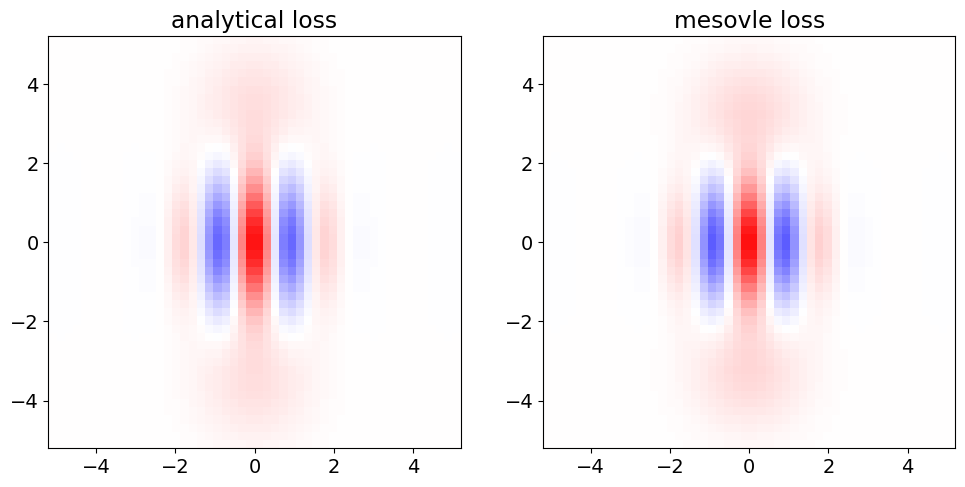

In [109]:
evolution_time_counter = 2

xvec = np.linspace(-5.1, 5.1,50)
cat, im  = char_func_grid(rhos[0][0],xvec)
#cat6 = char_func_grid(rhos[1][0],xvec)

cat_loss, im  = char_func_grid(rhos[0][evolution_time_counter],xvec)
t = evolution_time_counter*10
T1 = 100
eta = np.exp(-t/T1)

fig, ax = plt.subplots(1,2)

plot_analytical_loss(cat, xvec, eta, ax[0])
ax[0].set_aspect("equal")
ax[1].pcolormesh(xvec, xvec, cat_loss, vmin = -1, vmax = 1, cmap = "bwr")
ax[1].set_aspect("equal")

ax[0].set_title("analytical loss")
ax[1].set_title("mesovle loss")


Text(0.5, 1.0, 'mesovle loss')

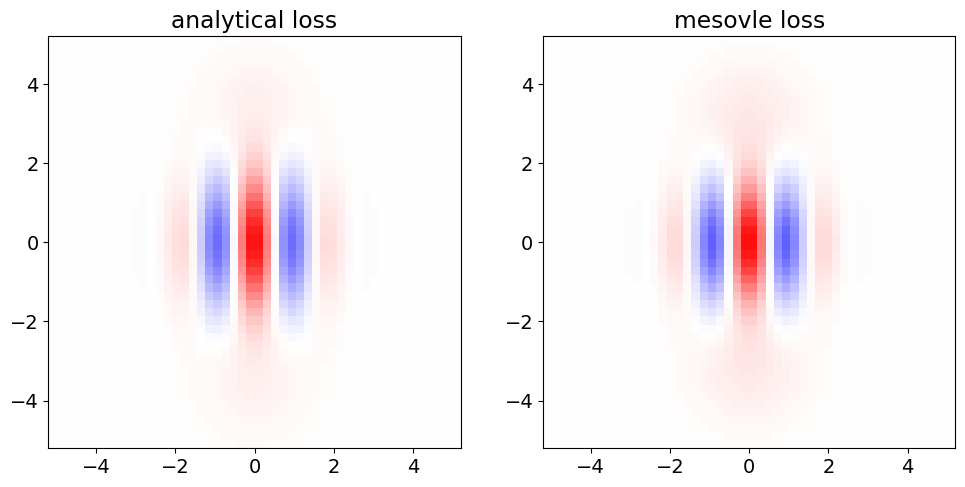

In [112]:
evolution_time_counter = 3

xvec = np.linspace(-5.1, 5.1,50)
cat, im  = char_func_grid(rhos[0][0],xvec)
#cat6 = char_func_grid(rhos[1][0],xvec)

cat_loss, im  = char_func_grid(rhos[0][evolution_time_counter],xvec)
t = evolution_time_counter*10
T1 = 100
eta = np.exp(-t/T1)

fig, ax = plt.subplots(1,2)

plot_analytical_loss(cat, xvec, eta, ax[0])
ax[0].set_aspect("equal")
ax[1].pcolormesh(xvec, xvec, cat_loss, vmin = -1, vmax = 1, cmap = "bwr")
ax[1].set_aspect("equal")

ax[0].set_title("analytical loss")
ax[1].set_title("mesovle loss")

Text(0.5, 1.0, 'mesovle loss')

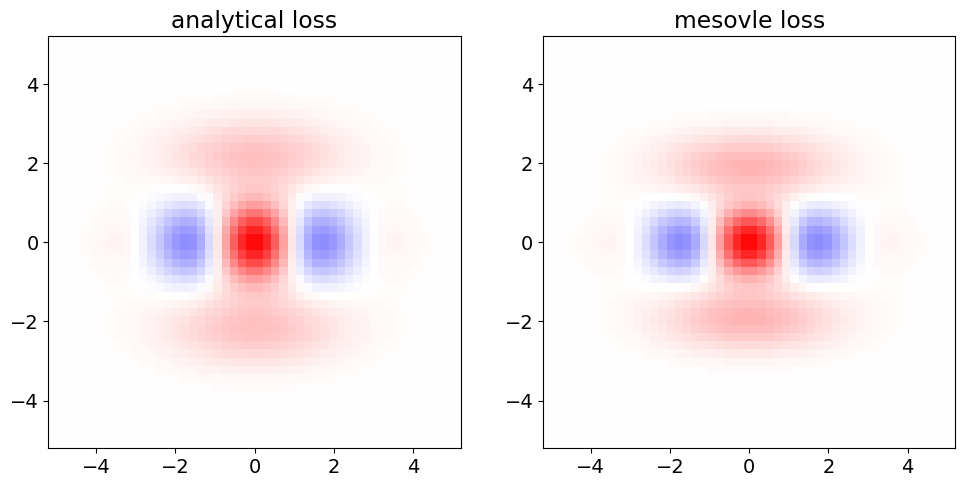

In [111]:
evolution_time_counter = 3

xvec = np.linspace(-5.1, 5.1,50)
cat, im  = char_func_grid(rhos[1][0],xvec)
#cat6 = char_func_grid(rhos[1][0],xvec)

cat_loss, im  = char_func_grid(rhos[1][evolution_time_counter],xvec)
t = evolution_time_counter*10
T1 = 100
eta = np.exp(-t/T1)

fig, ax = plt.subplots(1,2)

plot_analytical_loss(cat, xvec, eta, ax[0])
ax[0].set_aspect("equal")
ax[1].pcolormesh(xvec, xvec, cat_loss, vmin = -1, vmax = 1, cmap = "bwr")
ax[1].set_aspect("equal")

ax[0].set_title("analytical loss")
ax[1].set_title("mesovle loss")